In [1]:
import numpy as np
import math
import copy
import time

In [2]:
#Open + read file
a = open('multidim-data.txt', 'r')
sample = a.readlines()
sample = [x.strip('\n') for x in sample] 
sample = [x.split(',') for x in sample] 

#Delete all the attributes you don't care about
for i, asdf in enumerate(sample):
    del(asdf[7])
    del(asdf[0:4])
    
#Turn strings into floats
for i in range(len(sample)):
    for j in range(len(sample[i])):
        sample[i][j] = float(sample[i][j])
        


### Helper Functions

In [3]:
#distance metric, this seems to be one of the best ones for multidimensional analysis although you can change it if you like.
def hellinger_dist(sampleDist, PDF):
    coefficient = 0
    tempDist = copy.deepcopy(sampleDist)
    totalSum = np.sum(sampleDist)
    for i in indices:
        tempDist[i] = tempDist[i] / totalSum
    for i in indices:
        coefficient += math.sqrt(tempDist[i]*PDF[i])
    return math.sqrt(1-coefficient)

"""
You can use this to measure variance or as another distance metric, but most importantly, it can check for bias.
Using this to measure the distance between the sample distribution and the overall PDF, we can confirm that for any given grouping of elements into objects, there is some bias.
However, if we were to look at a large number of different groupings of elements into objects, we'd see that the bias goes away as long as the groupings are chosen symmetrically about the overall PDF.
Here, we just grouped randomly, which is an easy and fast way to make it symmetric.
"""
def euclidean_dist(sampleDist, PDF):
    dist = np.zeros([numBins for i in range(m)])
    tempDist = copy.deepcopy(sampleDist)
    totalSum = np.sum(sampleDist)
    for i in indices:
        tempDist[i] = tempDist[i]/totalSum
    for i in indices:
        dist[i] += tempDist[i] - PDF[i]
    return dist

In [4]:
#Recursive helper function to give us all indices so that we can get the values correctly for the multidimensional case.
#You should use this to set a global variable before you need to use it so you only need to call this once. If you call this
#function many times with many dimensions, it will slow down your code a lot.

def nd_range(start, stop, dims):
    if not dims:
        yield ()
        return
    for outer in nd_range(start, stop, dims - 1):
        for inner in range(start, stop):
            yield outer + (inner,)

### Main Code

In [5]:
#This assumes that your sample is currently an array of arrays, each array corresponding to an element and its elements being the
#values of the variables as floats.

#you have to define this global variable before you can run the rest of it.
numBins = 5
    
    
def sample_to_pdf(sample, numObjects): #sample is the sample that we wish to take a subsample from and numobjects is the number
#of groupings we wish to create for the main function.
    m = len(sample[0])
    n = len(sample)
    
    #Compute extrema for binning
    maxValues = np.zeros((m,))
    for i in range(m):
        maxValues[i] = -float('inf')
    for i in sample:
        for j in range(len(i)):
            if i[j] > maxValues[j]:
                maxValues[j] = i[j]
    for i in range(m):
        maxValues[i] += 0.0001

    minValues = np.zeros((m,))
    for i in range(m):
        minValues[i] = float('inf')
    for i in sample:
        for j in range(len(i)):
            if i[j] < minValues[j]:
                minValues[j] = i[j]
    
    

    binSize = (maxValues - minValues) / numBins
    #Create the bins and bin the sample so we get our pdfs as well as the overall pdf.
    tempList = [numObjects]
    tempList.extend([numBins for i in range(m)])
    distributions = np.zeros(tempList)
    overallPDF = np.zeros([numBins for i in range(m)])
    objectContents = [set() for i in range(numObjects)]
    for k, element in enumerate(sample):
        i = np.random.randint(0,numObjects)
        objectContents[i].add(k)
        pos = [0 for i in range(m)]
        for j in range(m):
            pos[j] = math.floor((element[j]-minValues[j]) / binSize[j])
        positions = tuple(pos)
        distributions[i][positions]+= 1
        overallPDF[positions]+=1
    weights = np.zeros((numObjects,))
    for i in range(numObjects):
        weights[i] = np.sum(distributions[i])
    overallPDF = overallPDF / np.sum(overallPDF)
    for i, split in enumerate(distributions):
        tempSum = np.sum(split)
        distributions[i] = split / tempSum
    return weights, distributions, overallPDF, objectContents

In [6]:
maxWeight = 10000
sampleProportion = 1/5
significanceLevel = 0.999
m = 3
w, p, overallPDF, objectContents =sample_to_pdf(sample, 6400)
indices = list(nd_range(0, numBins, m)) #global variable corresponding to all the indices so we only need to generate them once.
#It stores everything as tuples and we just call indices to get indices for multidimensional things since nested for loops don't
#work with an unknown number of dimensions.
def multi_dim_knapsack(w, p, maxWeight):
    n = len(w)
    m = len(p.shape)-1
    totalWeight = 0
    currentPDF = np.zeros([numBins for i in range(m)])
    contents = set()
    weight = max(w)
    #first, we take a simple random sample that has weight at most maxWeight/2. It should be similar to the population density.
    while True:
        i = np.random.randint(0,n)
        if i not in contents:
            if totalWeight + w[i] > maxWeight*sampleProportion:
                break
            else:
                contents.add(i)
                totalWeight += w[i]
                for k in indices:
                    currentPDF[k] += w[i]*p[i][k]
    #Now, we add objects to this sample to try to correct it and make it closer to the population density
    
    
    #This is the approach that adds 1 object at a time. This time, we just take anything that's significantly better
    currentDeviation = hellinger_dist(currentPDF, overallPDF)
    pairAdded = True
    numIts=0
    while pairAdded:
        counter = 0
        for i, weight in enumerate(w):
            if i not in contents and totalWeight+w[i] <= maxWeight:
                tempPDF = copy.deepcopy(currentPDF)
                for k in indices:
                    tempPDF[k] += w[i]*p[i][k]
                tempDeviation = hellinger_dist(tempPDF, overallPDF)
                if tempDeviation <= (significanceLevel)*currentDeviation:
                    currentDeviation = tempDeviation
                    totalWeight += w[i]
                    contents.add(i)
                    currentPDF = tempPDF
                    counter += 1
                    if totalWeight == maxWeight:
                        return contents, currentDeviation, currentPDF, totalWeight, numIts
        if counter == 0:
            pairAdded = False
        numIts += 1
    
    
    return contents, currentDeviation, currentPDF, totalWeight, numIts

In [7]:
start_time = time.time()
a, b, c, d, e = multi_dim_knapsack(w, p, maxWeight)
time_taken = time.time() - start_time
print(time_taken)

3.38767147064209


### Explanation of how to use the Code

When running your code on whatever data you are attempting to run this on, the body of the code should look something like this:

(define helper functions above)

(Read in the data as an array of floats or ints)

numBins = k (for best results, you want to have k as large as possible while still having on average 10+ elements in each bin)

maxWeight = 10000

sampleProportion = 1/5 (This parameter doesn't matter too much, just make it large enough that you can consistently create a relatively full sample)

significanceLevel = 0.9991 (Adjust this parameter manually for best results. Only change sampleProportion if you're having trouble consistently creating a relatively full sample)

w, p, overallPDF =sample_to_pdf(sample, n). 

(Here, n is just however many groups of elements you wish to create. Fewer -> faster runtime but too few -> we can't fit many objects into the subsample -> we get a bad subsample. Also, if there's too few, we will start with an empty sample as a single object fills up more than the sampleProportion, which breaks the code and causes it to not run).

m = 3

indices = list(nd_range(0, numBins, m))

a, b, c, d, e = multi_dim_knapsack(w, p, maxWeight)

sampleElements = set()

for i in a:

    for j in objectContents[i]:
    
        sampleElements.add(j)
        
sampleElements is the set corresponding to the chosen sample.

Finally, a tip about choosing the parameters:

You want to leave sampleProportion somewhere about 0.2 and only increase it if you're struggling to fill your subsample.

To choose significanceLevel, start off with a pretty high value: generally 0.9 for 100 groups of elements and then decrease the distance to 1 by half every time you multiply the number of groups of elements by 10.

Then, you run the algorithm. If the weight of the end result is close to sampleProportion*maxWeight, increase the parameter by a lot. If it's not close to either endpoint, increase it by a little. If the number of iterations (5th variable returned by the function) is 0 or 1, then decrease the parameter by a bit. Repeat this until you get satisfactory results.

In [8]:
d, b, e

(9999.0, 0.01584450852150025, 3)

You can check the quality of your results also by looking at the weight and the number of iterations for the sample. If you see 0 or 1 as the number of iterations, it means you accepted objects too easily. In these cases the weight will also be exactly 10000. If the number of iterations is 2, you still may want to consider trying again as termination after 2 iterations generally also means you accepted objects too easily.
Also, if the weight is not very close to maxWeight, then you were probably too restrictive with selecting objects. You generally want the sample to be close to being full, maybe at least 90 or 95% full.

Due to the randomness in this algorithm, even with well-chosen parameters you will occasionally get a result that is unsatisfactory for one of the reasons above. (This is also partly why it's so difficult to automate the parameter choosing). Don't be afraid to rerun the algorithm multiple times without changing the parameters: what's most important is making sure you get a good sample.

In [9]:
#Finally, we shall get which objects are in the sample we created.

sampleElements = set()
for i in a:
    for j in objectContents[i]:
        sampleElements.add(j)
print(sampleElements)

{131072, 32769, 131073, 98308, 98317, 65551, 131088, 15, 65556, 98334, 32799, 131104, 33, 32803, 32808, 41, 32810, 32811, 46, 32815, 131120, 131124, 65592, 98361, 131133, 131138, 131140, 131143, 98375, 65609, 65619, 131156, 98391, 32858, 131163, 93, 94, 98397, 131169, 65639, 103, 131178, 131186, 131193, 131194, 131195, 98428, 32893, 65663, 32895, 65665, 32899, 32900, 131, 131207, 137, 65678, 32912, 150, 32918, 65689, 65694, 32932, 32935, 98474, 32938, 173, 32944, 131249, 177, 131250, 98485, 98487, 32952, 32954, 131264, 65728, 98500, 196, 131270, 32966, 32964, 131274, 32971, 32972, 131277, 65744, 32982, 98529, 131301, 33005, 33008, 98546, 65791, 98564, 98566, 131338, 131342, 33040, 131357, 65824, 131360, 65827, 33062, 98600, 33072, 98608, 98610, 305, 131380, 310, 313, 65854, 65857, 131394, 323, 131396, 98628, 131398, 131399, 98634, 65868, 65870, 98640, 131409, 33106, 65874, 33108, 33109, 65875, 65881, 33114, 33121, 356, 33124, 358, 65894, 65905, 65907, 375, 65912, 131449, 33150, 384, 65

### Graphs Demonstrating Performance vs Number of Objects

In [10]:
import matplotlib.pyplot as plt

In [11]:
variance = np.zeros((7,))
sigLevels = [0.92, 0.943, 0.97, 0.985, 0.992, 0.998, 0.999]
sampleProportion = 0.2
for i, j in enumerate([100, 200, 400, 800, 1600, 3200, 6400]):
    significanceLevel = sigLevels[i]
    w, p, overallPDF, objectContents = sample_to_pdf(sample, j)
    a, b, c, d, e = multi_dim_knapsack(w, p, maxWeight)
    variance[i] = b


In [14]:
log_variance = np.zeros(7,)
for i in range(7):
    log_variance[i] = math.log(variance[i])

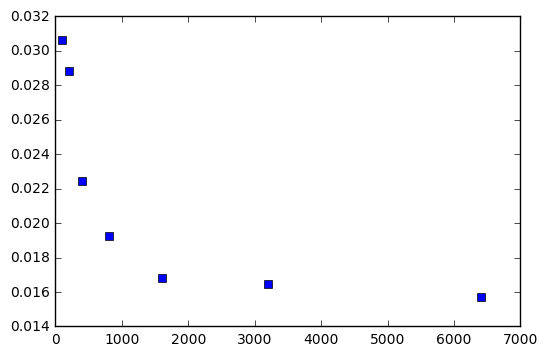

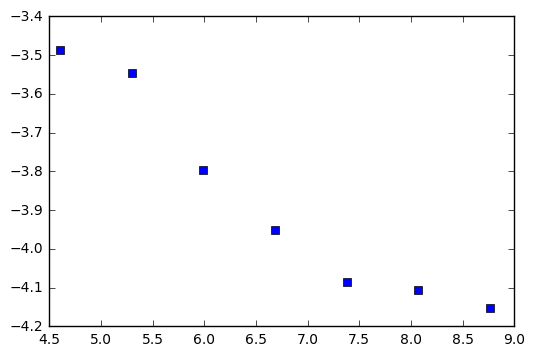

In [23]:
plt.plot([100, 200, 400, 800, 1600, 3200, 6400], variance, 'bs')
plt.show()
#The first graph shows some sort of behavior that suggest we probably want to look at a power model

X = np.array([math.log(100), math.log(200), math.log(400), math.log(800), math.log(1600), math.log(3200), math.log(6400)])

plt.plot(X, log_variance, 'bs')
plt.show()


In [16]:
from sklearn import linear_model
regModel = linear_model.LinearRegression()
regModel.fit(X.reshape(-1, 1), log_variance.reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [17]:
print (regModel.coef_)

[[-0.17571325]]


The second graph above looks quite good for linear regression. Although it is not ideal, the significance levels were computed with trial and error manually and thus are not completely optimal. If the significance levels were chosen perfectly, it is probable that we would get a graph very well suited to regression, allowing us to estimate the variance based on the number of objects. This gives us a good estimate of the tradeoff between runtime and accuracy as having more objects results in more runtime, but also greater accuracy.

As seen above, the slope is about -0.18, meaning that the variance is proportional to about $n^{-0.14}$. As the number of objects increases, however, the value of the significance level gets more difficult to compute and it requires more precision to consistently produce a good result. As such, there is a very significant runtime increase as n increases, as the algorithm runs in O(n) time and we have to increase the number of test runs to compute a good value for the significance level.

Also, the slope calculated here is not necessarily accurate due to the reason that the significance levels were chosen manually through trial and error. However, it is a general idea for estimating the number of objects you will need to get the degree of accuracy that you need.

As a side note, you can see below that using another distance metric, average euclidean distance, we also get a very similar looking graph. Hence, we can see that when we optimize on one distance metric, we tend to optimize for others as well. Furthermore, since average euclidean distance is the one that is most similar to the normal way of calculating variance for a parameter, this shows that this is probably a good estimate of the variance.

In [21]:
variance1 = np.zeros((7,))
for i, j in enumerate([100, 200, 400, 800, 1600, 3200, 6400]):
    significanceLevel = sigLevels[i]
    w, p, overallPDF, objectContents = sample_to_pdf(sample, j)
    a, b, c, d, e = multi_dim_knapsack(w, p, maxWeight)
    diff = euclidean_dist(c, overallPDF)
    variance1[i] = np.sum(abs(diff))/125

log_variance1 = [0 for i in range(7)]
for i in range(7):
    log_variance1[i] = math.log(variance1[i])

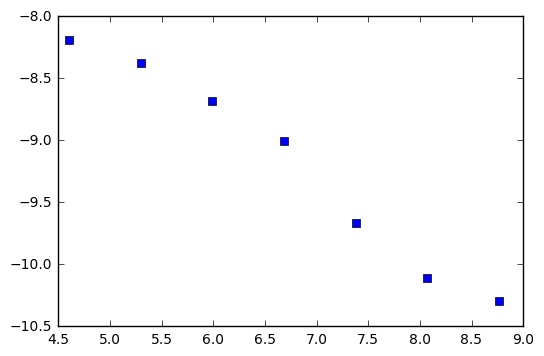

In [24]:
plt.plot(X, log_variance1, 'bs')
plt.show()